# SpectralDefocusCam Iterative Reconstruction Demo

In [16]:
import sys
sys.path.insert(0, "../")

import matplotlib.pyplot as plt
import scipy.io
import dataset.precomp_dataset as ds
import utils.helper_functions as helper
import utils.diffuser_utils as diffuser_utils
import utils.psf_utils as psf_utils
import train
import PIL.Image as Image
import numpy as np, torch
import os, tqdm
import glob

# Change this to GPU or CPU depending on your machine 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = "cuda:0"

%load_ext autoreload
%autoreload 2

if "cuda" in device:
    print(torch.cuda.get_device_name(device))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
NVIDIA TITAN Xp


### View calibration data and image

In [40]:
psf_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/singlepos/psfs_ONAXIS_telecent25um"
test_meas_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/exp_meas/duckincar"
calib_mat_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/calib_matrix_11_10_2023_2_preprocessed/calibration_matrix_450-810_30chan_stride12_avg12.mat"

#exp params
sim_blur = True
w_init = [0.003, 0.018, 0.04, 0.06, 0.095]
crop_center = [1000, 2000]
crop_size = [768, 768]
patch_size = [256, 256]
ksizes = [7, 21, 45, 55, 65]
exposures = [1 / 662, 1 / 110, 1 / 45, 1 / 30, 1 / 21]
num_ims = len(exposures)

stack_depth = 5 # number of images in your stack
blurstride = 1 # stride between ordered blur levels of your measurements

config = {
    "device": device,
    "mask_dir": calib_mat_path_rel,
    "psf_dir": psf_path_rel,
    "data_precomputed": False,
    "forward_model_params": {
        "stack_depth": stack_depth,
        "psf": {
            "lri": False,
            "stride": blurstride,
            "symmetric": True,
            "optimize": False,
            "padded_shape": crop_size[0],
            "exposures": exposures[:stack_depth*blurstride:blurstride],
            "w_init": w_init,
        },
        "operations": {
            "sim_blur": False,
            "sim_meas": False,
            "adjoint": False,
            "spectral_pad": False,
            "roll": False
        }
    },
    "recon_model_params": {
        "model_name": "fista",
        "iters": 800,
        "prox_method": 'tv',
        "tau": 0.5,
        "tv_lambda": 0.501,
        "tv_lambdaw": 0.001,
        "tv_lambdax": 10,
        "lowrank_lambda": 0.4,
        "print_every": 20
    },
    "batch_size": 1,
    "patch_size": patch_size,
    "patch_crop": crop_size,
    "image_center": crop_center,
    "loss_function": {
        "name": "mse",
        "params": {
        }
    }
}

model = train.get_model(config, device=device)

Reading psf: 100%|██████████| 5/5 [00:00<00:00, 26.81it/s]


Scaled psfs by values: [1.0, 0.1661631419939577, 0.06797583081570997, 0.045317220543806644, 0.03172205438066465]
cuda:0


In [18]:
# Experimental measurements
files = sorted(glob.glob(os.path.join(test_meas_path_rel, "*.bmp")))
prep = lambda x: diffuser_utils.preprocess_meas(
    x, 
    center=crop_center,
    crop_size=crop_size[0],
    dim=patch_size[0],
    outlier_std_threshold=3
)
measurements = [prep(np.array(Image.open(x))) for x in tqdm.tqdm(files, "Preprocessing")]
sel_meas_stack = torch.tensor(np.stack(measurements, axis=0))[:stack_depth*blurstride:blurstride]

sel_meas_stack = sel_meas_stack / torch.max(sel_meas_stack)
sel_meas_stack = sel_meas_stack - torch.min(model.model1.mask, dim=1, keepdim=True).values.cpu()[0]

Preprocessing: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


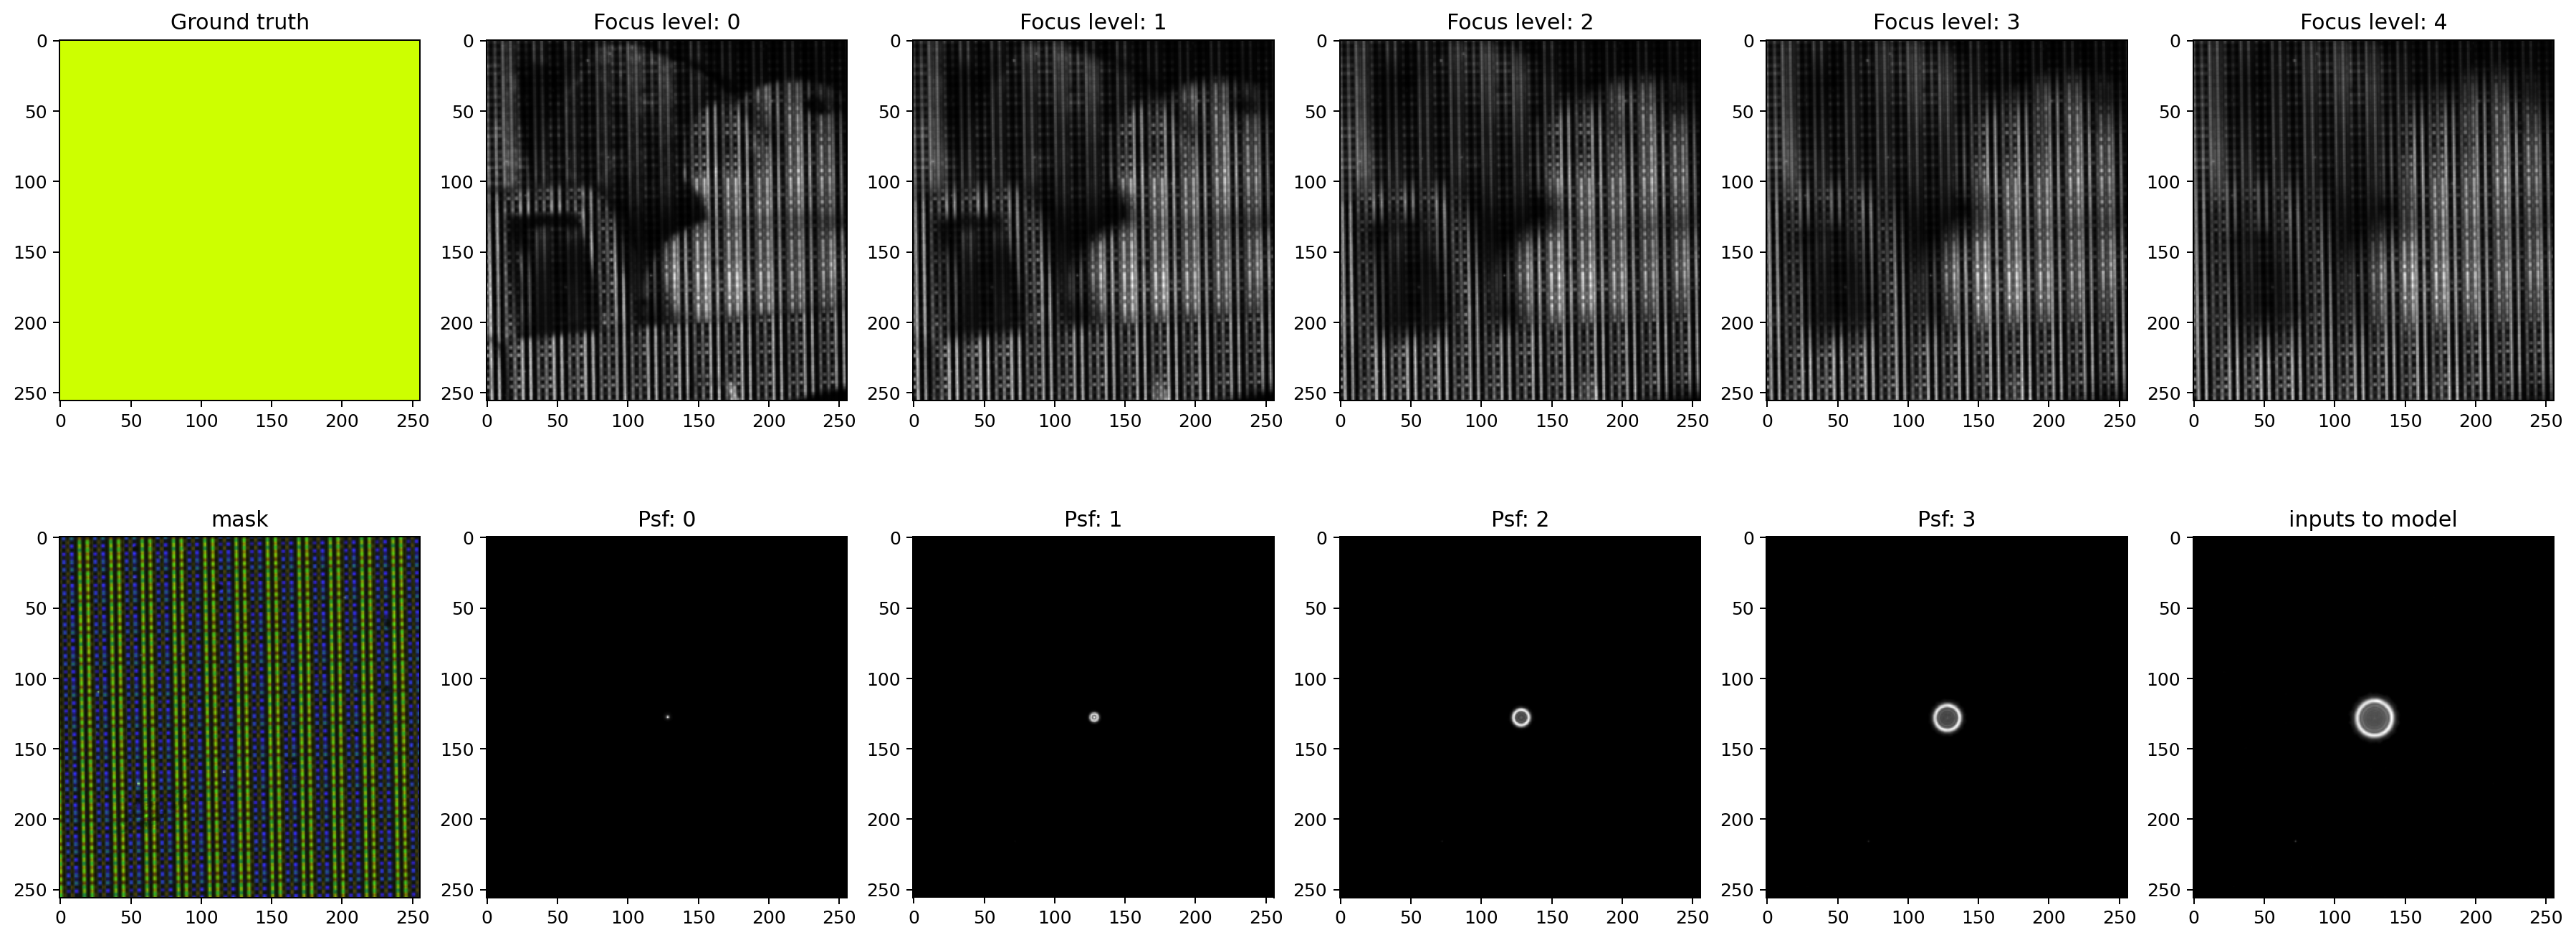

In [29]:
plot = lambda x: helper.value_norm(helper.stack_rgb_opt_30(np.transpose(x, (1,2,0))))
fig, ax = plt.subplots(2, len(sel_meas_stack)+1, figsize = (4*len(sel_meas_stack), 8))
fig.set_dpi(180)
for i in range(len(sel_meas_stack)+1):
    if i == 0:
        ax[0][i].imshow(plot(np.ones((30, patch_size[0], patch_size[1]))))
        ax[0][i].set_title(f"Ground truth")
        ax[1][i].imshow(plot(model.model1.mask[0].cpu().numpy()))
        ax[1][i].set_title(f"mask")
    else:
        ax[0][i].imshow(sel_meas_stack[i-1].cpu().numpy(), cmap='gray')
        ax[0][i].set_title(f"Focus level: {i-1}")
        ax[1][i].imshow(model.model1.psfs[i-1].cpu().numpy(), cmap='gray')
        ax[1][i].set_title(f"Psf: {i-1}")
plt.title("inputs to model")
plt.tight_layout()
plt.show()

In [39]:
torch.max(sel_meas_stack[2])

tensor(0.9252, dtype=torch.float64)

## Run model with fista recon

In [18]:
mask_binned = diffuser_utils.load_mask(calib_mat_path_rel)
mask_pyr = diffuser_utils.load_mask(calib_mat_path_rel, downsample="pyramid")

In [22]:
helper.plot_cube_interactive(mask_binned)

FigureWidget({
    'data': [{'type': 'image',
              'uid': '6da3820c-40a4-452b-b146-ac2ffd6e6076',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 26,  38, 154],
                           [ 25,  37, 145],
                           [ 10,  12,  38],
                           ..., 
                           [  5,   6,   7],
                           [  9,  11,   6],
                           [ 47,  88,  12]],
                   
                          [[ 20,  66, 118],
                           [ 18,  58,  98],
                           [ 10,  18,  35],
                           ..., 
                           [  5,   6,   7],
                           [ 10,  11,   6],
                           [ 44,  83,  12]],
                   
                          [[ 24,  59, 145],
                           [ 22,  54, 130],
                           [ 10,  17,  38],
                           ..., 
                           [  9,   6

In [21]:
helper.plot_cube_interactive(mask_pyr)

FigureWidget({
    'data': [{'type': 'image',
              'uid': '41e4f7ae-f9a3-4e5e-8e2e-312492ff34cc',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 32,  48, 190],
                           [ 30,  44, 175],
                           [ 15,  22,  75],
                           ..., 
                           [  8,  10,   8],
                           [ 12,  17,   7],
                           [ 41,  76,  11]],
                   
                          [[ 25,  75, 154],
                           [ 23,  67, 134],
                           [ 13,  29,  63],
                           ..., 
                           [  8,  10,   8],
                           [ 12,  16,   7],
                           [ 40,  72,  11]],
                   
                          [[ 26,  69, 157],
                           [ 24,  62, 140],
                           [ 14,  28,  66],
                           ..., 
                           [ 10,   8

In [17]:
# # load the learned recon model
lrnd_cfg = "/home/cfoley_waller/defocam/defocuscamdata/models/checkpoint_train_02_07_2024_lsi_adjoint_adjnoise.yml/2024_02_12_19_05_28/training_config.yml" 
weights_path = "/home/cfoley_waller/defocam/defocuscamdata/models/checkpoint_train_02_07_2024_lsi_adjoint_adjnoise.yml/2024_02_12_19_05_28/saved_model_ep216_testloss_0.13865037393514756.pt"
lrnd_cfg = helper.read_config(lrnd_cfg)

lrnd_cfg["preload_weights"], lrnd_cfg["checkpoint_dir"] = True, weights_path
lrnd_model = train.get_model(lrnd_cfg, device=device).model2
lrnd_model.eval()

#set in fista recon
model.model2.recon_model = lrnd_model
model.model2.learned_inversion = True

In [43]:
model.model2.iters = 800
model.model2.tv_lambda = 0.901
model.model2.tv_lambdax = 10 # 10
model.model2.tv_lambdaw = 0.001
model.model2.print_every = 20

#model.model1.mask = model.model1.mask +0.05 #- torch.min(model.model1.mask, dim=1, keepdim=True).values

In [23]:
helper.plot_cube_interactive(np.transpose(model.model1.mask.cpu().numpy()[0], (1,2,0)))

FigureWidget({
    'data': [{'type': 'image',
              'uid': '478e2f9f-633a-4e10-85d7-06ac40a553ef',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 24,  28,   7],
                           [ 33,  40,  60],
                           [ 36,  41, 157],
                           ..., 
                           [ 15,  20,  23],
                           [ 16,  22,  16],
                           [ 18,  23,   9]],
                   
                          [[ 21,  24,   6],
                           [ 31,  44,  57],
                           [ 36,  64, 167],
                           ..., 
                           [ 15,  20,  23],
                           [ 16,  22,  16],
                           [ 17,  23,   9]],
                   
                          [[ 22,  24,   5],
                           [ 31,  43,  53],
                           [ 35,  61, 160],
                           ..., 
                           [ 30,  26

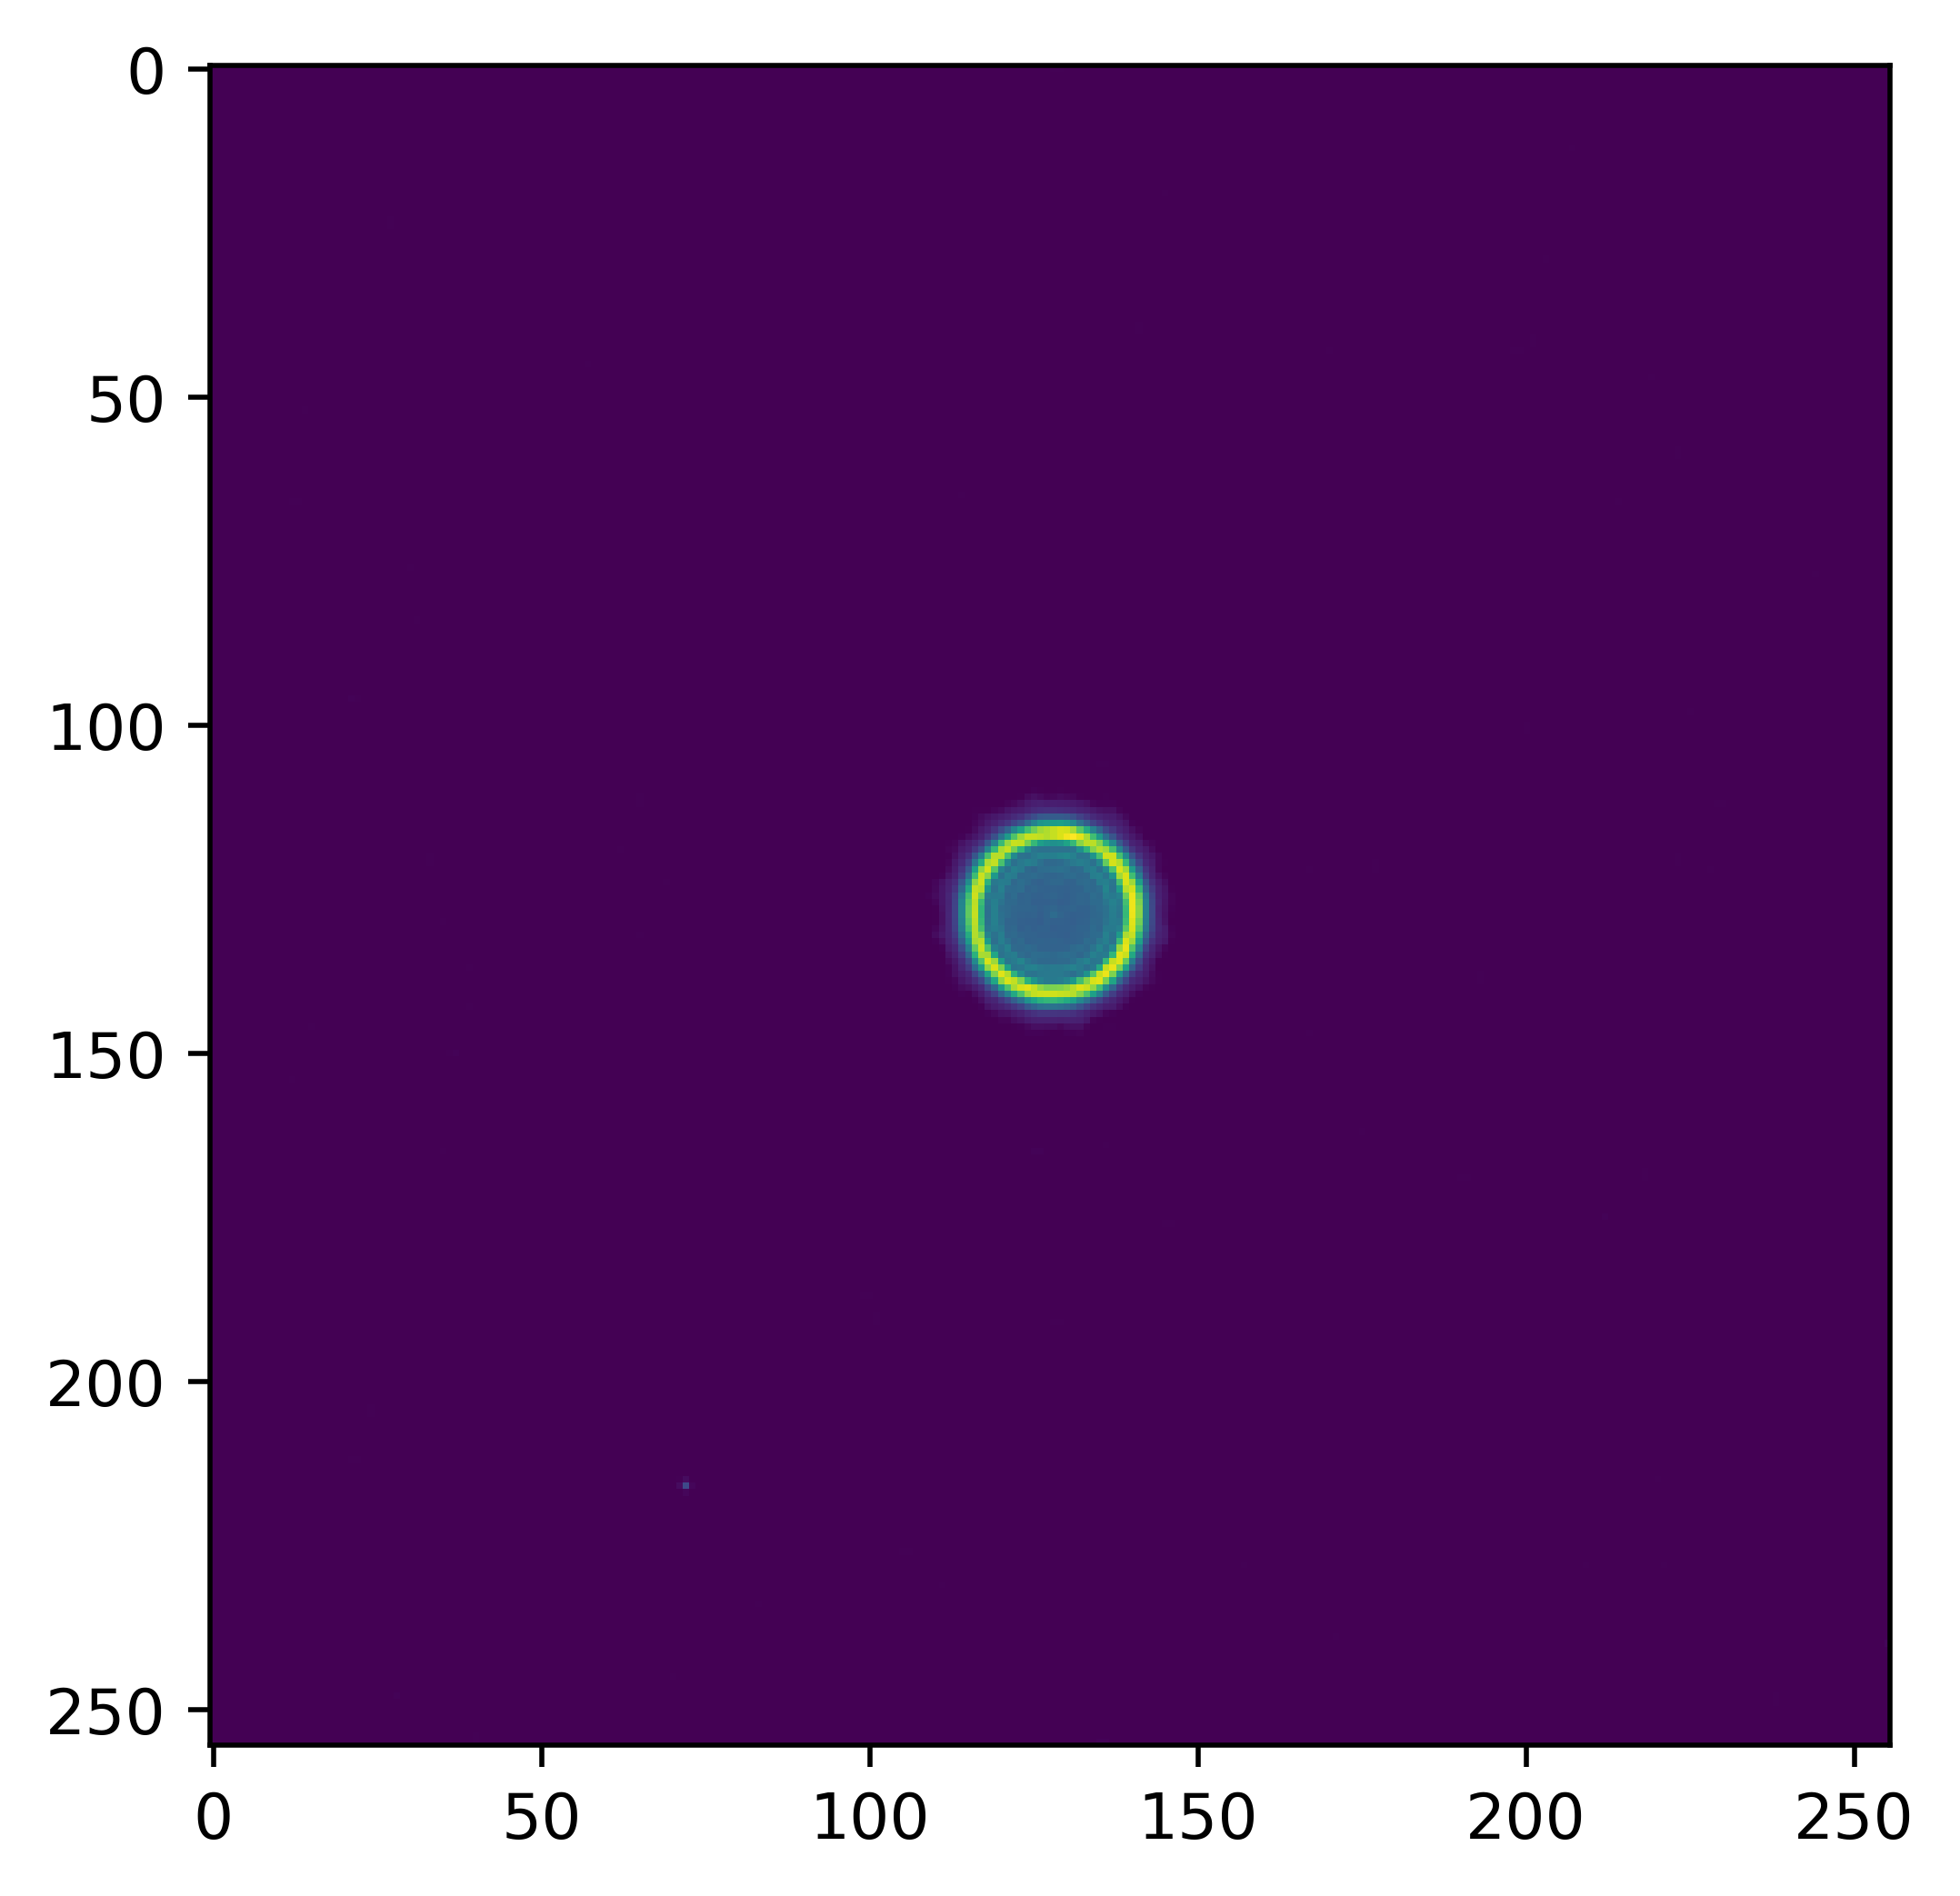

In [25]:
plt.imshow(model.model1.psfs[4].cpu().numpy())

iteration:  0  loss:  tensor(3894.6594, device='cuda:0', dtype=torch.float64)


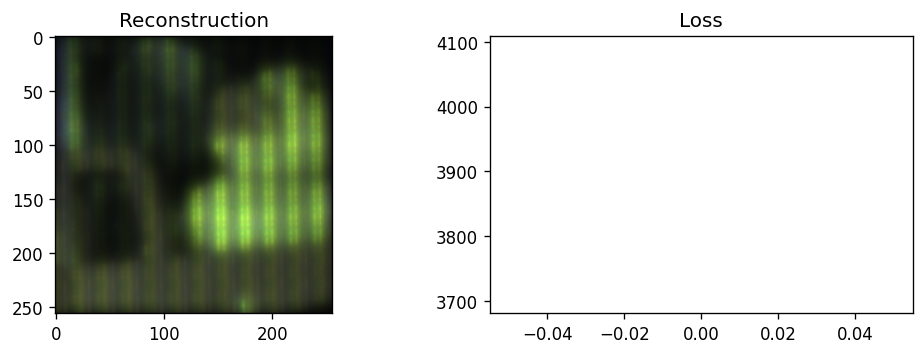

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  20  loss:  tensor(221.0436, device='cuda:0', dtype=torch.float64)


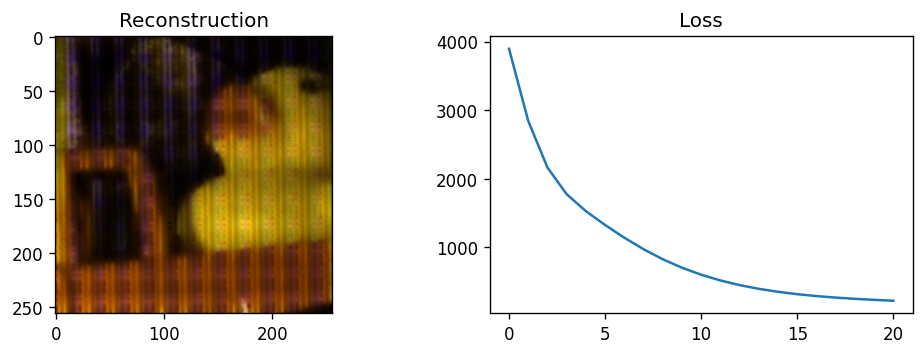

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  40  loss:  tensor(101.0720, device='cuda:0', dtype=torch.float64)


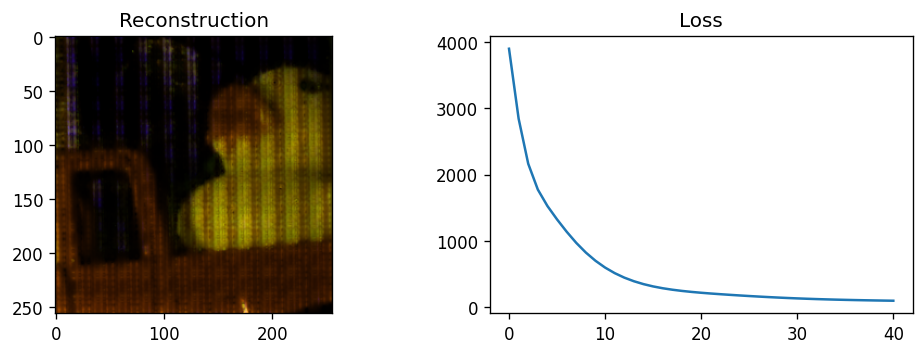

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  60  loss:  tensor(79.9469, device='cuda:0', dtype=torch.float64)


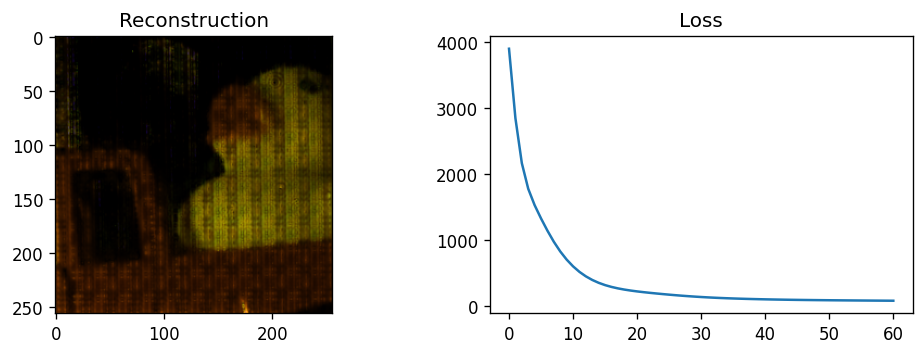

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  80  loss:  tensor(71.0054, device='cuda:0', dtype=torch.float64)


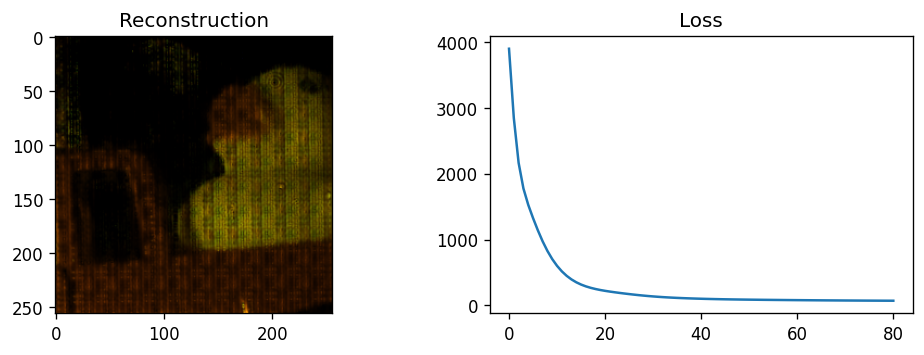

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  100  loss:  tensor(66.7447, device='cuda:0', dtype=torch.float64)


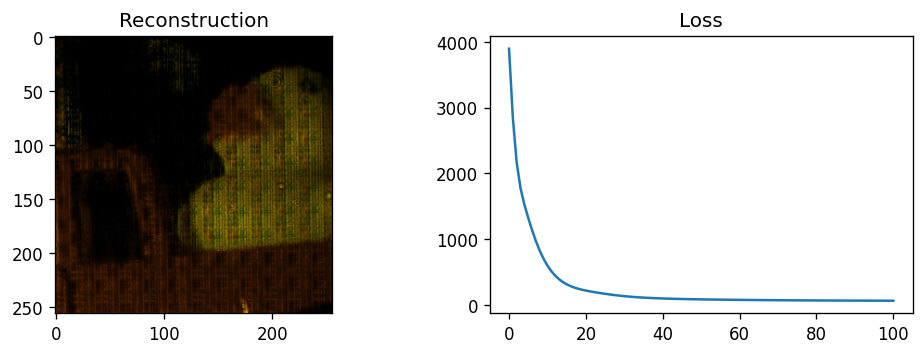

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  120  loss:  tensor(61.8116, device='cuda:0', dtype=torch.float64)


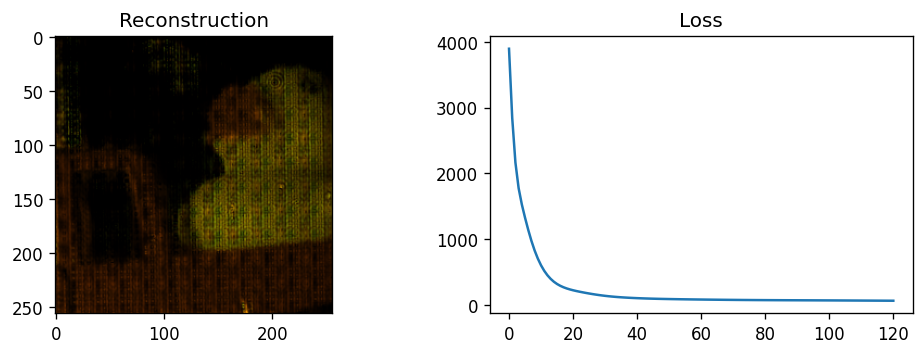

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  140  loss:  tensor(58.0670, device='cuda:0', dtype=torch.float64)


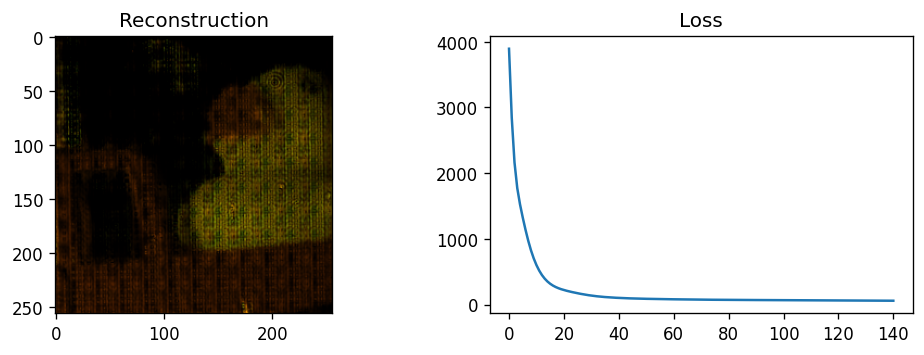

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  160  loss:  tensor(56.2535, device='cuda:0', dtype=torch.float64)


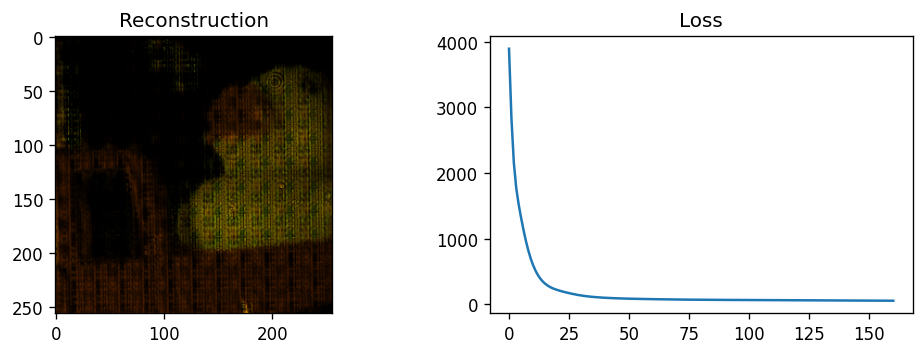

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  180  loss:  tensor(55.2595, device='cuda:0', dtype=torch.float64)


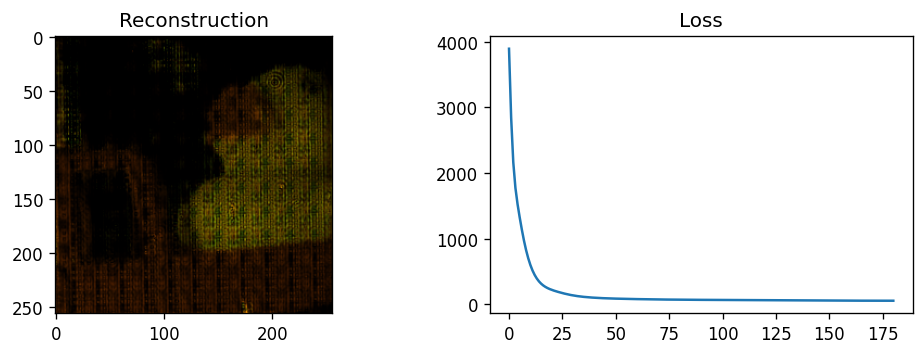

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  200  loss:  tensor(53.9365, device='cuda:0', dtype=torch.float64)


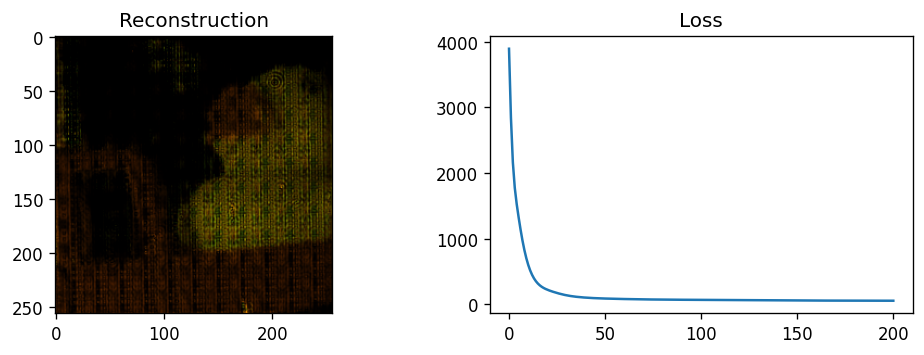

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  220  loss:  tensor(52.6952, device='cuda:0', dtype=torch.float64)


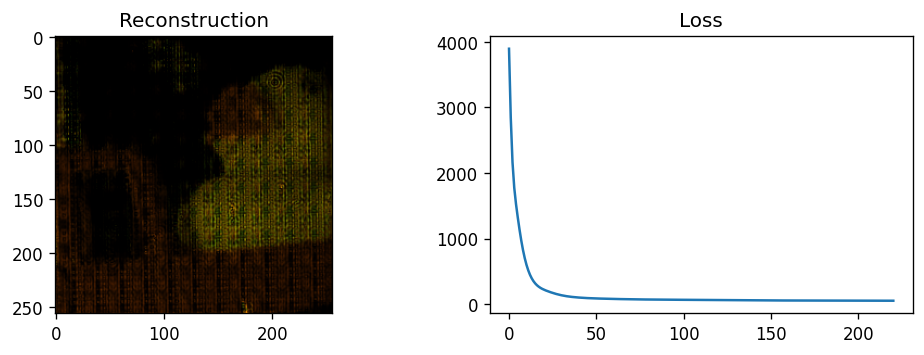

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  240  loss:  tensor(51.8481, device='cuda:0', dtype=torch.float64)


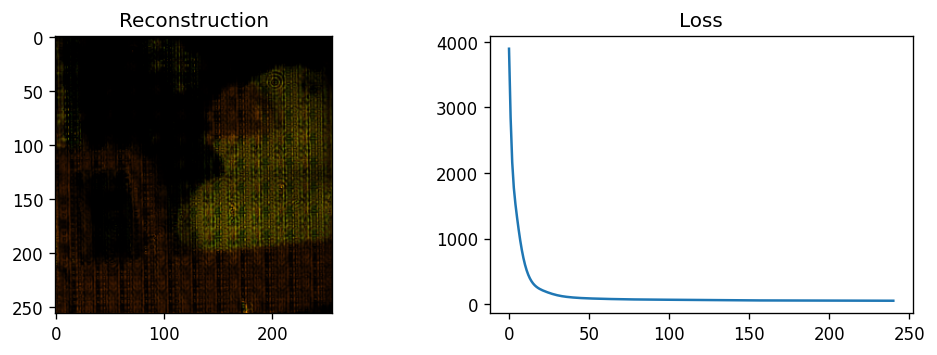

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  260  loss:  tensor(51.1574, device='cuda:0', dtype=torch.float64)


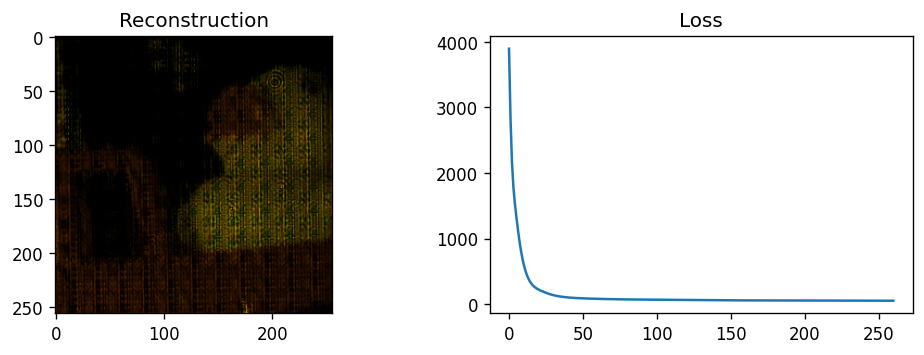

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  280  loss:  tensor(50.3852, device='cuda:0', dtype=torch.float64)


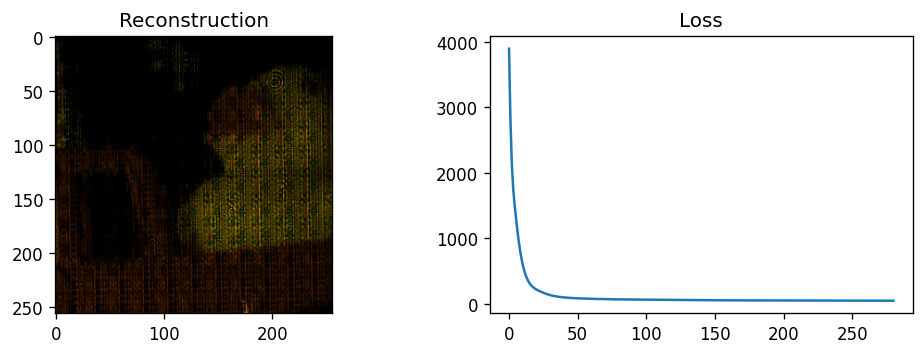

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  300  loss:  tensor(49.6440, device='cuda:0', dtype=torch.float64)


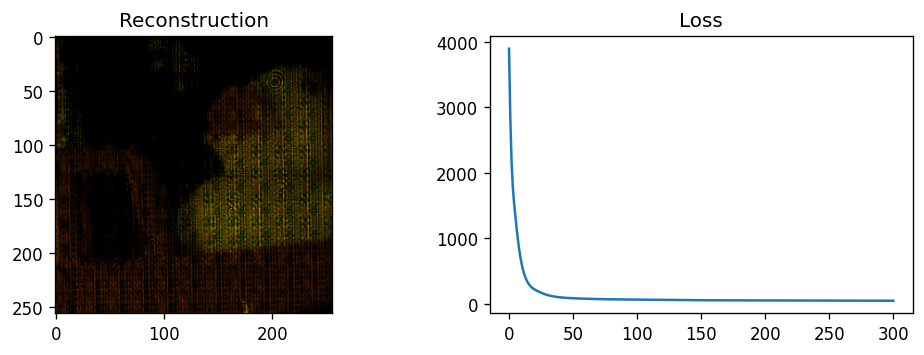

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  320  loss:  tensor(49.1293, device='cuda:0', dtype=torch.float64)


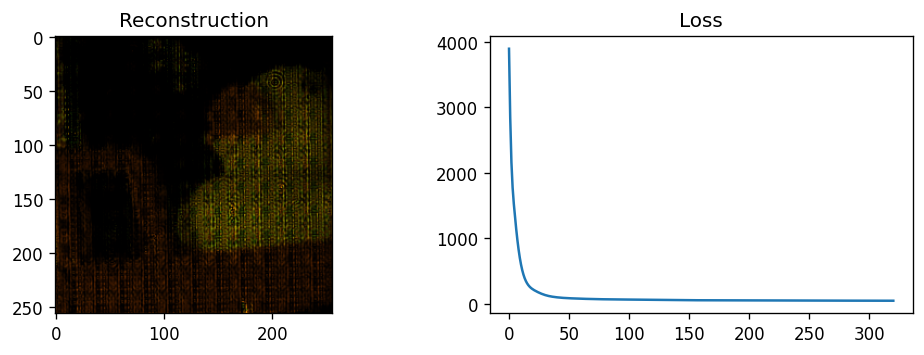

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  340  loss:  tensor(48.7862, device='cuda:0', dtype=torch.float64)


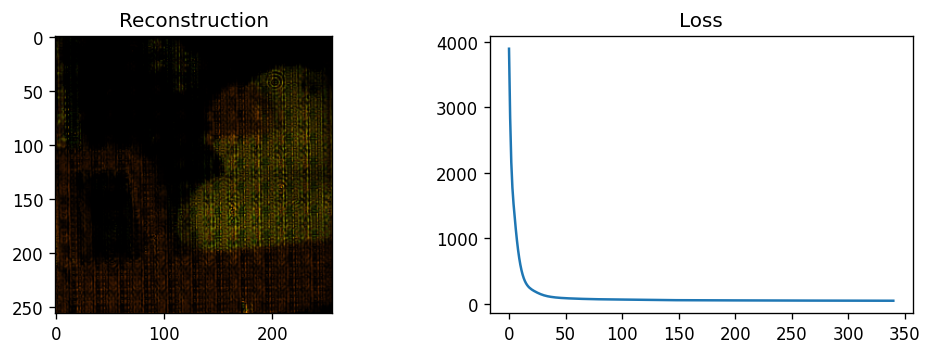

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  360  loss:  tensor(48.4904, device='cuda:0', dtype=torch.float64)


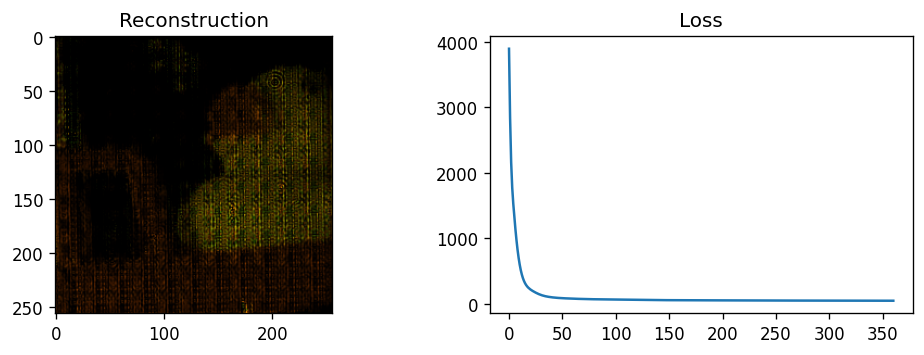

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  380  loss:  tensor(48.1818, device='cuda:0', dtype=torch.float64)


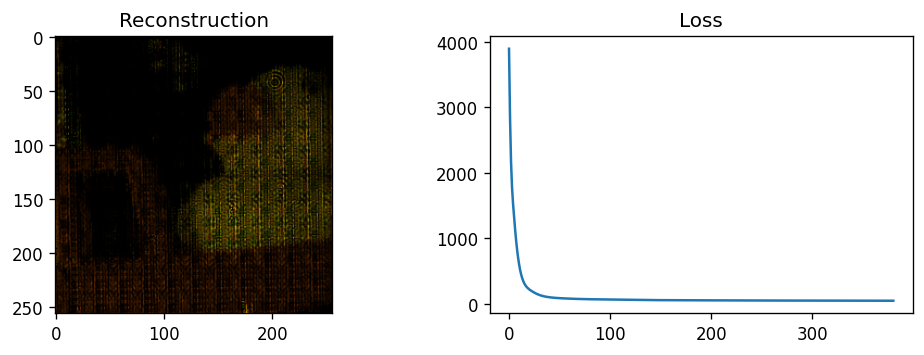

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  400  loss:  tensor(47.8834, device='cuda:0', dtype=torch.float64)


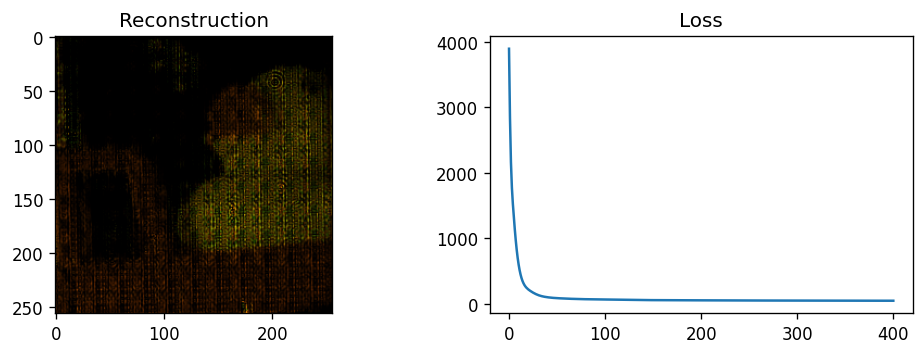

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  420  loss:  tensor(47.6169, device='cuda:0', dtype=torch.float64)


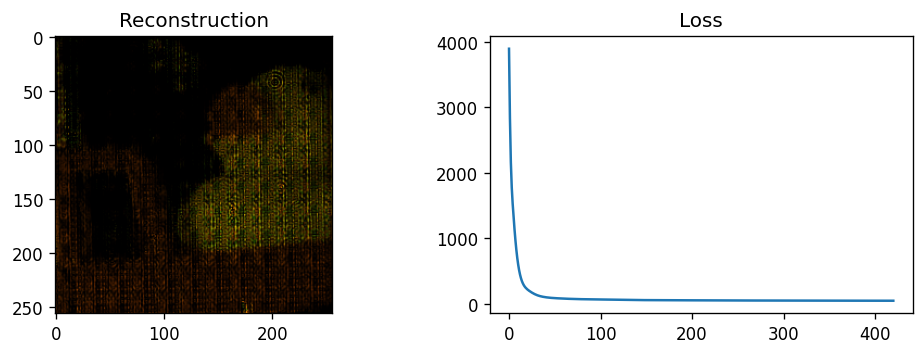

KeyboardInterrupt: 

In [44]:
measurement = sel_meas_stack.unsqueeze(0).to(device)
out = model(measurement)

### Visualize Outputs

In [33]:
prev_recon = np.load("/home/cfoley_waller/defocam/defocam_dataset_for_neerja/recons/hatoncar_800_0.901_0.001_10.npy")
helper.plot_cube_interactive(prev_recon)

FigureWidget({
    'data': [{'type': 'image',
              'uid': 'ac27ebfe-4e5e-47ea-aec5-bff73cd300e7',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 14,   7,   2],
                           [ 14,   7,   2],
                           [ 14,   8,   1],
                           ..., 
                           [  3,   3,   2],
                           [  4,   4,   2],
                           [  5,   5,   2]],
                   
                          [[ 13,   7,   2],
                           [ 13,   7,   2],
                           [ 13,   7,   1],
                           ..., 
                           [  3,   3,   2],
                           [  4,   4,   2],
                           [  6,   6,   2]],
                   
                          [[ 13,   7,   2],
                           [ 13,   7,   1],
                           [ 13,   7,   1],
                           ..., 
                           [  3,   3

In [22]:
recon = model.model2.out_img
helper.plot_cube_interactive(recon)

FigureWidget({
    'data': [{'type': 'image',
              'uid': 'e511c73d-d4c1-4c75-acb1-612b3c760b1f',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 15,   9,   3],
                           [ 16,   9,   3],
                           [ 16,  10,   3],
                           ..., 
                           [  4,   4,   3],
                           [  4,   4,   3],
                           [  4,   4,   4]],
                   
                          [[ 17,   9,   3],
                           [ 17,  10,   3],
                           [ 18,  10,   4],
                           ..., 
                           [  4,   4,   3],
                           [  4,   4,   3],
                           [  4,   4,   4]],
                   
                          [[ 18,  10,   3],
                           [ 19,  10,   3],
                           [ 19,  11,   3],
                           ..., 
                           [  4,   4

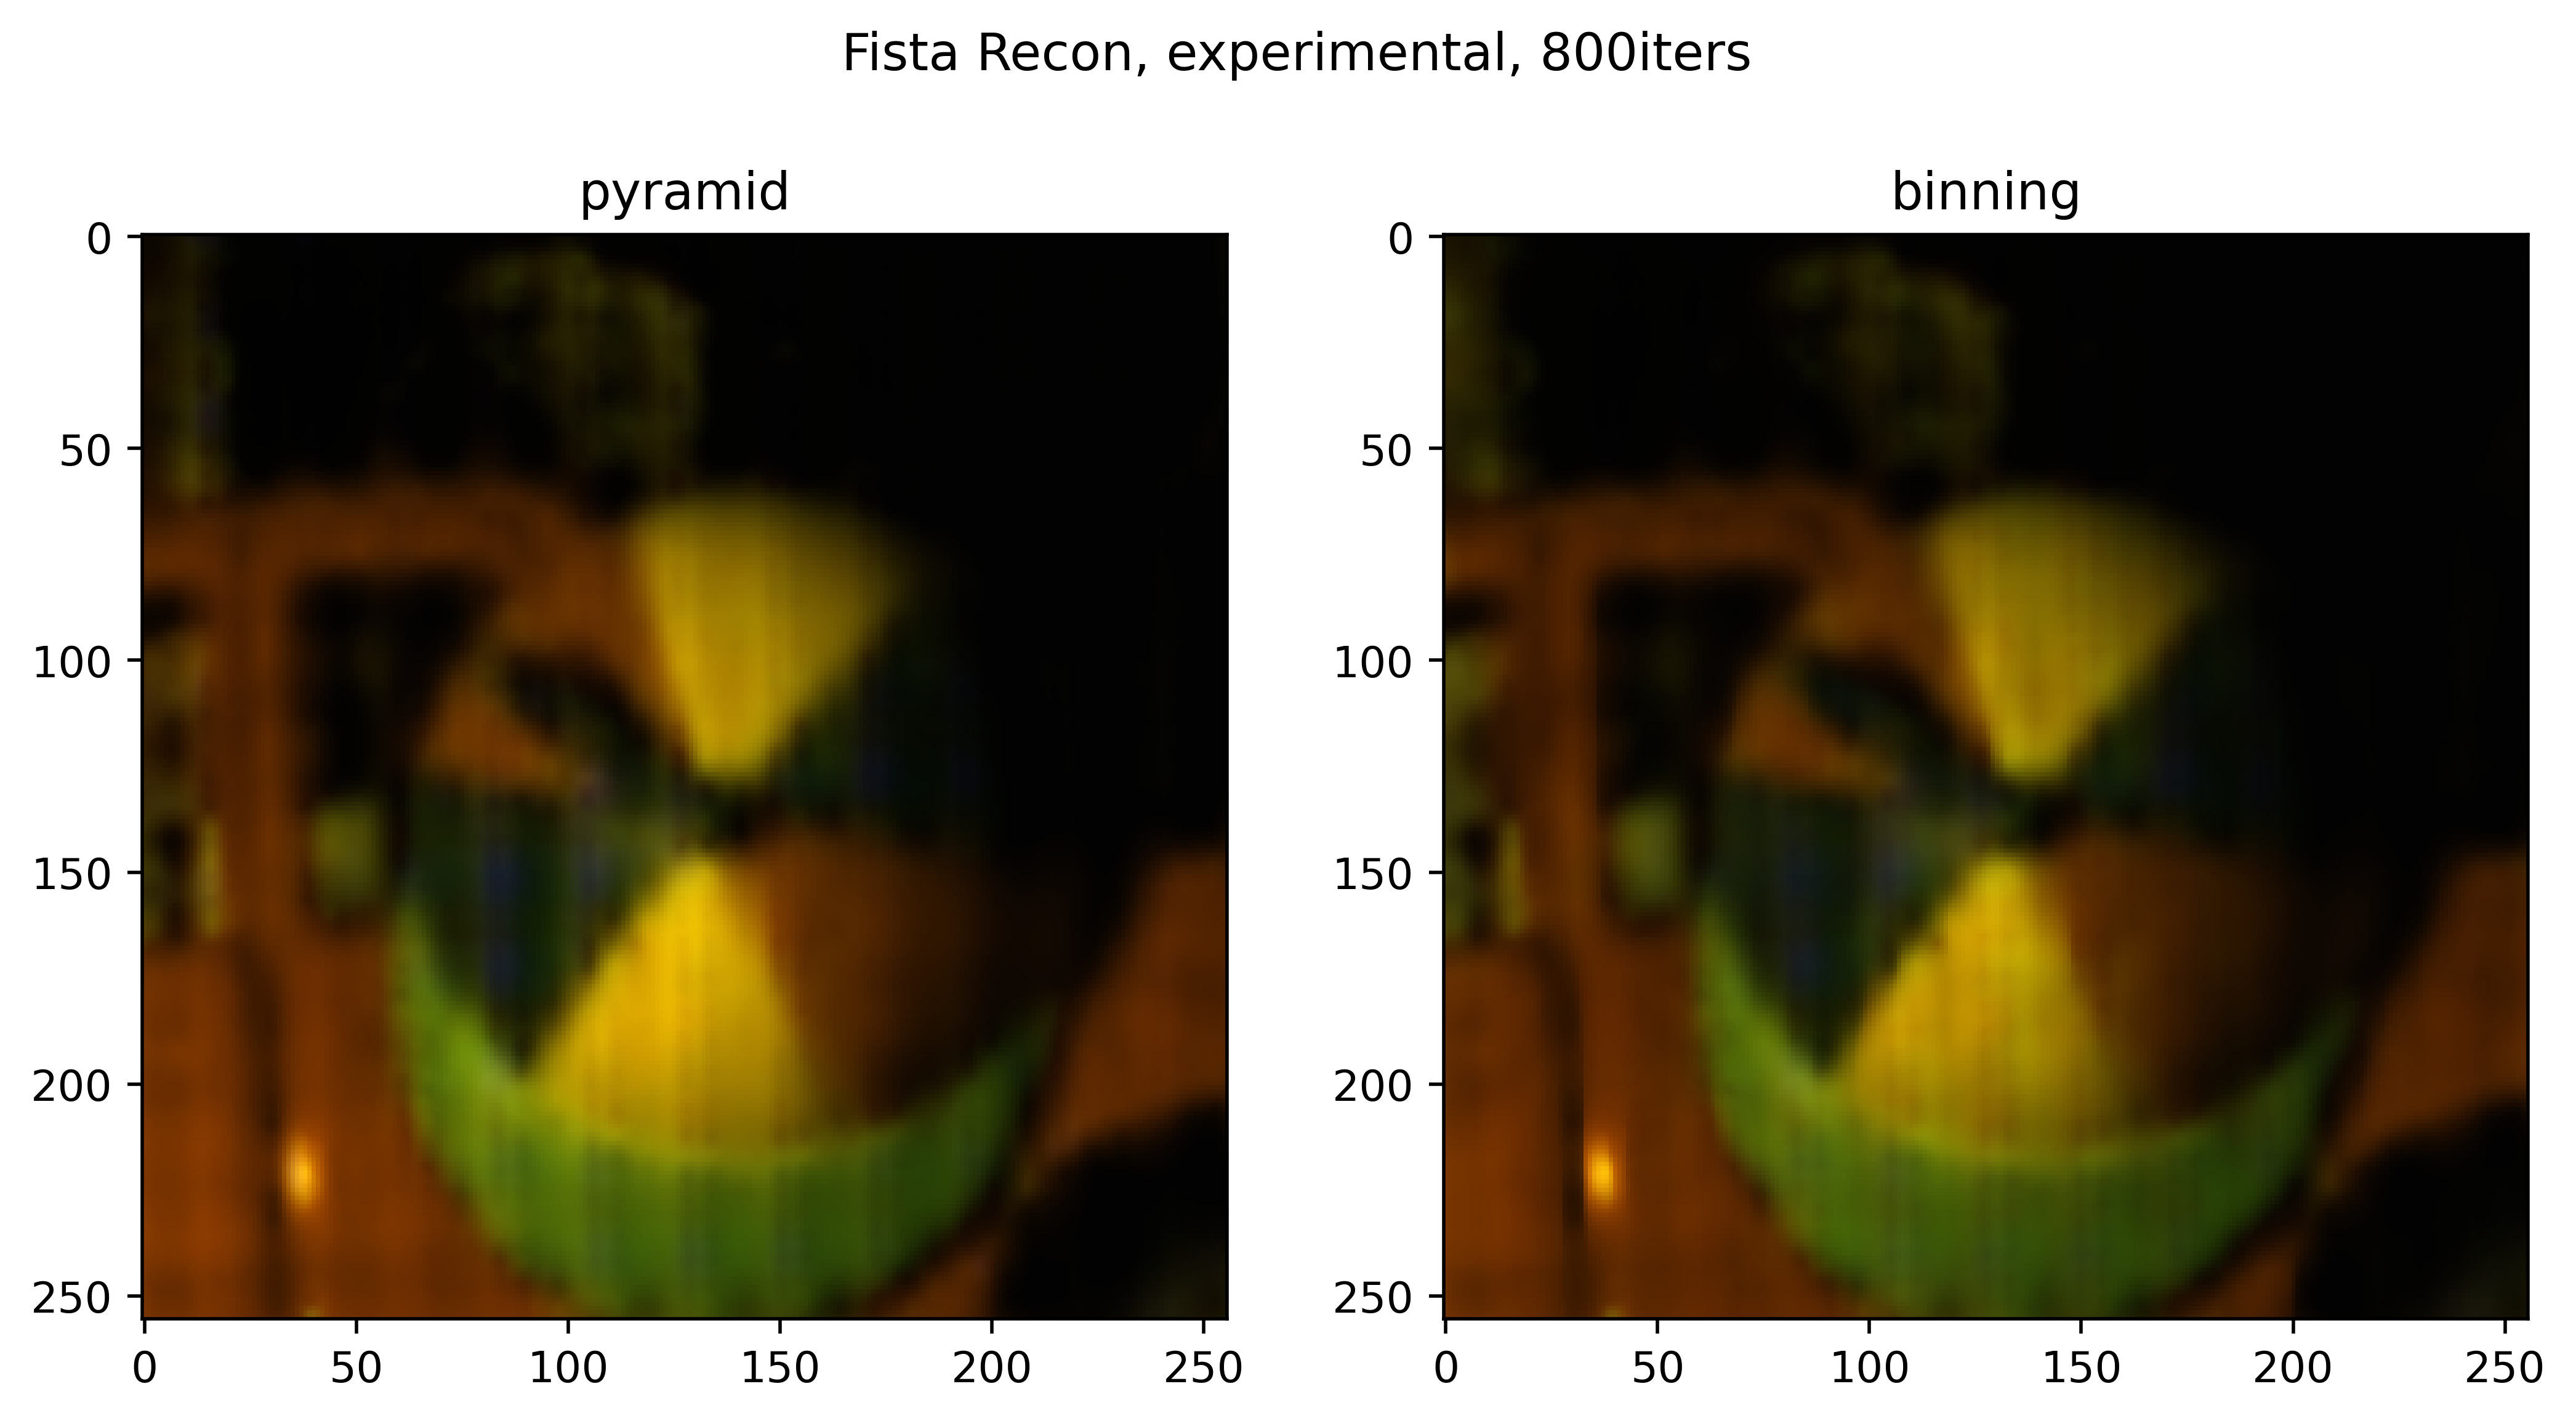

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].imshow(helper.value_norm(helper.stack_rgb_opt_30(prev_recon)))
ax[0].set_title("pyramid")
ax[1].imshow(helper.value_norm(helper.stack_rgb_opt_30((recon))))
ax[1].set_title("binning")

plt.suptitle("Fista Recon, experimental, 800iters")
plt.show()

In [85]:
fig, a# Visualize in 3D scan
helper.plt3D(helper.pre_plot(recon, False), title="Spectral Reconstruction")

interactive(children=(IntSlider(value=1, description='r', max=29), Output()), _dom_classes=('widget-interact',…

In [90]:
# Visualize spectra
helper.plot_cube_interactive(recon)

FigureWidget({
    'data': [{'type': 'image',
              'uid': '10357562-dc99-4a01-a496-53bd68616595',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[15,  9,  3],
                           [15,  9,  3],
                           [16, 10,  3],
                           ..., 
                           [ 3,  3,  3],
                           [ 3,  3,  3],
                           [ 3,  3,  3]],
                   
                          [[16,  9,  3],
                           [16,  9,  3],
                           [16, 10,  3],
                           ..., 
                           [ 3,  3,  3],
                           [ 3,  3,  3],
                           [ 3,  3,  3]],
                   
                          [[16,  9,  3],
                           [17, 10,  3],
                           [17, 10,  3],
                           ..., 
                           [ 3,  3,  2],
                           [ 3,  3,  3],

In [98]:
helper.plot_cube_interactive(model.model2.mask.get())

FigureWidget({
    'data': [{'type': 'image',
              'uid': '97120bc3-1321-49b7-9f4c-bc194f8a8e0e',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 15,  16,  10],
                           [ 24,  29,  64],
                           [ 27,  29, 160],
                           ..., 
                           [  6,   8,  26],
                           [  7,  10,  18],
                           [  9,  12,  12]],
                   
                          [[ 12,  12,   8],
                           [ 22,  32,  60],
                           [ 28,  53, 170],
                           ..., 
                           [  6,   8,  26],
                           [  7,  10,  19],
                           [  8,  11,  12]],
                   
                          [[ 13,  13,   8],
                           [ 22,  31,  56],
                           [ 26,  50, 163],
                           ..., 
                           [ 21,  14

In [103]:
helper.plot_cube_interactive(meas_stack.cpu().numpy().transpose(1,2,0))

FigureWidget({
    'data': [{'type': 'image',
              'uid': 'c322e618-baa1-4c88-98a7-5f15ad8ddd80',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[56, 54, 52],
                           [28, 27, 24],
                           [14, 15, 12],
                           ..., 
                           [ 3,  4,  3],
                           [10, 11, 10],
                           [35, 35, 33]],
                   
                          [[72, 69, 67],
                           [35, 34, 31],
                           [20, 21, 17],
                           ..., 
                           [ 3,  4,  2],
                           [10, 11, 10],
                           [34, 34, 32]],
                   
                          [[72, 69, 69],
                           [36, 35, 33],
                           [20, 20, 17],
                           ..., 
                           [ 3,  4,  3],
                           [10, 11,  9],

In [16]:
recon.shape

(256, 256, 30)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


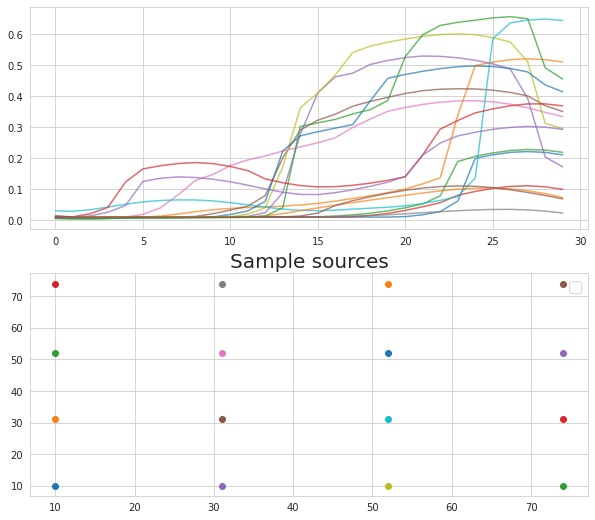

In [97]:
import seaborn
seaborn.set_style("whitegrid")

recon_norm = (recon - np.min(recon)) / np.max(recon - np.min(recon))
fig, ax = plt.subplots(2,1, figsize=(10,9))
for i in range(30, recon.shape[0], recon.shape[0]//4):
    for j in range(30, recon.shape[1], recon.shape[1]//4):
        ax[0].plot(recon_norm[i,j], alpha=0.7)
        ax[1].scatter(i//3,j//3)

ax[1].set_title("Sample sources", fontsize=20)
plt.legend(fontsize=15, loc="upper right")
plt.show()